In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/dasha_loans/

/content/drive/MyDrive/dasha_loans


In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from termcolor import colored
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm
from copy import deepcopy

## Data Preparation

In [ ]:
train_data_path = './train.csv'
test_data_path = './test_bqCt9Pv.csv'

In [ ]:
train_dataframe = pd.read_csv(train_data_path)
test_dataframe = pd.read_csv(test_data_path)

In [ ]:
def write_head_of_dataframe(df, fname):
  new_fname = fname.split('/')
  new_fname[-1] = 'head_' + new_fname[-1]
  new_fname = '/'.join(new_fname)

  train_dataframe.head(10).to_csv(new_fname)

  print(f'{fname} ->', colored('head in', 'green', attrs=['bold']), f'-> {new_fname}')

write_head_of_dataframe(train_dataframe, train_data_path)
write_head_of_dataframe(test_dataframe, test_data_path)

./train.csv -> head in -> ./head_train.csv
./test_bqCt9Pv.csv -> head in -> ./head_test_bqCt9Pv.csv


In [ ]:
# train_dataframe.dtypes == 'O'#.to_list()

### Data content check

In [ ]:
def write_data_description(df: pd.DataFrame, fname: str):
  new_fname = fname.split('/')
  new_fname[-1] = 'description_' + new_fname[-1]
  new_fname = '/'.join(new_fname)

  df.describe().to_csv(new_fname)

  print(f'{fname} ->', colored('is described in', 'green', attrs=['bold']), f'-> {new_fname}')
  

write_data_description(train_dataframe, train_data_path)
write_data_description(test_dataframe, test_data_path)

./train.csv -> is described in -> ./description_train.csv
./test_bqCt9Pv.csv -> is described in -> ./description_test_bqCt9Pv.csv


In [ ]:
train_dataframe.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [ ]:
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Date.of.Birth                        233154 non-null  object 
 9   Employment.Type                      225493 non-null  object 
 10  DisbursalDate                        233154 non-null  object 
 11  State_ID     

In [ ]:
train_dataframe.describe()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,...,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default
count,233154.000000,233154.000000,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,...,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000
mean,535917.573376,54356.993528,7.586507e+04,74.746530,72.936094,19638.635035,69.028054,3396.880247,7.262243,1549.477148,...,0.007244,5.427793e+03,7.295923e+03,7.179998e+03,1.310548e+04,3.232684e+02,0.381833,0.097481,0.206615,0.217071
std,68315.693711,12971.314171,1.894478e+04,11.456636,69.834995,3491.949566,22.141304,2238.147502,4.482230,975.261278,...,0.111079,1.702370e+05,1.831560e+05,1.825925e+05,1.513679e+05,1.555369e+04,0.955107,0.384439,0.706498,0.412252
min,417428.000000,13320.000000,3.700000e+04,10.030000,1.000000,10524.000000,45.000000,1.000000,1.000000,1.000000,...,0.000000,-5.746470e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,476786.250000,47145.000000,6.571700e+04,68.880000,14.000000,16535.000000,48.000000,1511.000000,4.000000,713.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,535978.500000,53803.000000,7.094600e+04,76.800000,61.000000,20333.000000,86.000000,2970.000000,6.000000,1451.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,595039.750000,60413.000000,7.920175e+04,83.670000,130.000000,23000.000000,86.000000,5677.000000,10.000000,2362.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.999000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000
max,671084.000000,990572.000000,1.628992e+06,95.000000,261.000000,24803.000000,156.000000,7345.000000,22.000000,3795.000000,...,8.000000,3.603285e+07,3.000000e+07,3.000000e+07,2.564281e+07,4.170901e+06,35.000000,20.000000,36.000000,1.000000


In [ ]:
pd.set_option('display.max_rows', 500)
display(train_dataframe.isnull().sum())

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

### Transform all `object` values into vectors

In [ ]:
categorical_cols = train_dataframe.select_dtypes(include=['object']).columns
categorical_cols

Index(['Date.of.Birth', 'Employment.Type', 'DisbursalDate',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'AVERAGE.ACCT.AGE',
       'CREDIT.HISTORY.LENGTH'],
      dtype='object')

In [ ]:
train_dataframe['Employment.Type'] = train_dataframe['Employment.Type'].replace(np.nan, 'unknown')

We can see that in the column `Employment.Type` there are a lot of `null` values and following the data descriptions this values are categorical so let's change this values for some new class and then turn all categorical data into one-hot vectors.

In [ ]:
train_dataframe['Date.of.Birth'] = pd.to_datetime(train_dataframe['Date.of.Birth'], format='%d-%m-%y')
train_dataframe['DisbursalDate'] = pd.to_datetime(train_dataframe['DisbursalDate'], format='%d-%m-%y')

train_dataframe['Age'] = (train_dataframe['DisbursalDate'] - train_dataframe['Date.of.Birth']) / np.timedelta64(1, 'Y')

In [ ]:
test_dataframe['Date.of.Birth'] = pd.to_datetime(test_dataframe['Date.of.Birth'], format='%d-%m-%y')
test_dataframe['DisbursalDate'] = pd.to_datetime(test_dataframe['DisbursalDate'], format='%d-%m-%y')

test_dataframe['Age'] = (train_dataframe['DisbursalDate'] - test_dataframe['Date.of.Birth']) / np.timedelta64(1, 'Y')

In [ ]:
def time_data_vec_1(_datetime):
#   _datetime = datetime.strptime(s, "%d-%m-%y")
  return np.array([_datetime.day, _datetime.month, _datetime.year])

def time_data_vec_2(s: str):
  _s = s.split(' ')
  return np.array([eval(_s[0].split('yrs')[0]), eval(_s[1].split('mon')[0])])

functions_to_vectorize_time_data = {'Date.of.Birth': time_data_vec_1,
                                    'DisbursalDate': time_data_vec_1,
                                    'AVERAGE.ACCT.AGE': time_data_vec_2,
                                    'CREDIT.HISTORY.LENGTH': time_data_vec_2}

cols = list(functions_to_vectorize_time_data.keys())
cols
# k = 0
# kn = 80
# functions_to_vectorize_time_data[cols[k]](train_dataframe[cols[k]][kn])

['Date.of.Birth', 'DisbursalDate', 'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH']

In [ ]:
for col in tqdm(cols):
  train_dataframe[col] = train_dataframe[col].map(functions_to_vectorize_time_data[col])
  test_dataframe[col] = test_dataframe[col].map(functions_to_vectorize_time_data[col])

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# split columns into multiple columns if they contain an array

def perform_splitting(df, col):
  print(col)
  n = len(df[col][0])
  for i in range(n):
    df[col + f'_{i}'] = df[col].map(lambda x: x[i])
  return df

for col in tqdm(cols):
  train_dataframe = perform_splitting(train_dataframe, col)
  test_dataframe = perform_splitting(test_dataframe, col)

  0%|          | 0/4 [00:00<?, ?it/s]

Date.of.Birth
Date.of.Birth
DisbursalDate
DisbursalDate
AVERAGE.ACCT.AGE
AVERAGE.ACCT.AGE
CREDIT.HISTORY.LENGTH
CREDIT.HISTORY.LENGTH


In [ ]:
train_dataframe = train_dataframe.drop(columns=cols)
test_dataframe = test_dataframe.drop(columns=cols)

In [ ]:
train_dataframe

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment.Type,State_ID,...,Date.of.Birth_0,Date.of.Birth_1,Date.of.Birth_2,DisbursalDate_0,DisbursalDate_1,DisbursalDate_2,AVERAGE.ACCT.AGE_0,AVERAGE.ACCT.AGE_1,CREDIT.HISTORY.LENGTH_0,CREDIT.HISTORY.LENGTH_1
0,420825,50578,58400,89.55,67,22807,45,1441,Salaried,6,...,1,1,1984,3,8,2018,0,0,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,Self employed,6,...,31,7,1985,26,9,2018,1,11,1,11
2,417566,53278,61360,89.63,67,22807,45,1497,Self employed,6,...,24,8,1985,1,8,2018,0,0,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,Self employed,6,...,30,12,1993,26,10,2018,0,8,1,3
4,539055,52378,60300,88.39,67,22807,45,1495,Self employed,6,...,9,12,1977,26,9,2018,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,626432,63213,105405,60.72,34,20700,48,1050,Salaried,6,...,1,8,1988,26,10,2018,1,9,3,3
233150,606141,73651,100600,74.95,34,23775,51,990,Self employed,6,...,5,12,1988,23,10,2018,0,6,0,6
233151,613658,33484,71212,48.45,77,22186,86,2299,Salaried,4,...,1,6,1976,24,10,2018,0,0,0,0
233152,548084,34259,73286,49.10,77,22186,86,2299,Salaried,4,...,26,3,1994,29,9,2018,0,0,0,0


In [ ]:
def risk_preproc(risk):
    if 'Very Low' in risk:
        risk = 'Very Low Risk'
    elif 'Low' in risk :
        risk = 'Low Risk'
    elif 'Medium' in risk :
        risk = 'Medium Risk'
    elif 'Very High' in risk:
        risk = 'Very High Risk'
    elif 'High' in risk :
        risk = 'High Risk'
    else:
        risk = 'Not Scored'
    return risk

train_dataframe['PERFORM_CNS.SCORE.DESCRIPTION'] = train_dataframe['PERFORM_CNS.SCORE.DESCRIPTION'].map(risk_preproc)
test_dataframe['PERFORM_CNS.SCORE.DESCRIPTION'] = test_dataframe['PERFORM_CNS.SCORE.DESCRIPTION'].map(risk_preproc)

In [ ]:
coluns_to_onehot = ['Employment.Type', 'PERFORM_CNS.SCORE.DESCRIPTION']
train_dataframe = pd.get_dummies(train_dataframe, prefix=coluns_to_onehot)
test_dataframe = pd.get_dummies(test_dataframe, prefix=coluns_to_onehot)

In [ ]:
cols_to_drop = ['UniqueID','manufacturer_id', 'State_ID', 'Passport_flag','MobileNo_Avl_Flag', 'Driving_flag']
train_dataframe.drop(columns=cols_to_drop, inplace=True)
test_dataframe.drop(columns=cols_to_drop, inplace=True)

In [ ]:
train_dataframe.head()

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,Current_pincode_ID,Employee_code_ID,Aadhar_flag,PAN_flag,VoterID_flag,...,CREDIT.HISTORY.LENGTH_1,Employment.Type_Salaried,Employment.Type_Self employed,Employment.Type_unknown,PERFORM_CNS.SCORE.DESCRIPTION_High Risk,PERFORM_CNS.SCORE.DESCRIPTION_Low Risk,PERFORM_CNS.SCORE.DESCRIPTION_Medium Risk,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored,PERFORM_CNS.SCORE.DESCRIPTION_Very High Risk,PERFORM_CNS.SCORE.DESCRIPTION_Very Low Risk
0,50578,58400,89.55,67,22807,1441,1998,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,47145,65550,73.23,67,22807,1502,1998,1,0,0,...,11,0,1,0,0,0,1,0,0,0
2,53278,61360,89.63,67,22807,1497,1998,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3,57513,66113,88.48,67,22807,1501,1998,1,0,0,...,3,0,1,0,0,0,0,0,1,0
4,52378,60300,88.39,67,22807,1495,1998,1,0,0,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 49 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   disbursed_amount                              233154 non-null  int64  
 1   asset_cost                                    233154 non-null  int64  
 2   ltv                                           233154 non-null  float64
 3   branch_id                                     233154 non-null  int64  
 4   supplier_id                                   233154 non-null  int64  
 5   Current_pincode_ID                            233154 non-null  int64  
 6   Employee_code_ID                              233154 non-null  int64  
 7   Aadhar_flag                                   233154 non-null  int64  
 8   PAN_flag                                      233154 non-null  int64  
 9   VoterID_flag                                  23

In [ ]:
y_train_init = train_dataframe['loan_default']
X_train_init = train_dataframe.drop(columns=['loan_default'])


# y_test = test_dataframe['loan_default']
X_test_init = test_dataframe#.drop(columns=['loan_default'])

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time

In [ ]:
models_configurations = {
                        #  "Nearest Neighbors": KNeighborsClassifier(3),
                         "ExtraTreesClassifier": ExtraTreesClassifier(n_estimators=100, random_state=0),
                         "LogisticRegression": LogisticRegression(random_state=0),
                         "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators=100, max_depth=7),
                         "Decision Tree": DecisionTreeClassifier(max_depth=5),
                         "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                         "Neural Net": MLPClassifier(alpha=1, max_iter=1000),
                         "AdaBoost": AdaBoostClassifier(),
                         "Naive Bayes": GaussianNB(),
                         "QDA": QuadraticDiscriminantAnalysis(),
                         }

In [ ]:
X = RobustScaler().fit_transform(X_train_init)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_train_init, test_size=0.2, random_state=42, stratify=y_train_init,
)

metrics_clf = {'f1_score': f1_score, 
               'accuracy_score': accuracy_score, 
               'recall_score': recall_score, 
               'precision_score': precision_score}

res = {name: {} for name in models_configurations}


# iterate over classifiers
for name, clf in models_configurations.items():
    ts = time()
    print(f'{name} -> ', end='')
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_test)
    
    for metric_name, metric in metrics_clf.items():
        res[name][metric_name] = metric(y_test, y_val_pred)

    tn = time()
    print(colored('Done!', 'green', attrs=['bold']), end='\t')
    print(f'time: {tn - ts}')



ExtraTreesClassifier -> Done!	time: 48.995434522628784
LogisticRegression -> 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Done!	time: 6.016196250915527
GradientBoostingClassifier -> Done!	time: 257.5744287967682
Decision Tree -> 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!	time: 2.0373117923736572
Random Forest -> 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!	time: 0.8226277828216553
Neural Net -> Done!	time: 87.82912182807922
AdaBoost -> Done!	time: 26.479602813720703
Naive Bayes -> Done!	time: 0.24857735633850098
QDA -> 

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done!	time: 1.1834981441497803


In [ ]:
from tabulate import tabulate
table = []
metrics_names = list(metrics_clf.keys())
for clf_name in res:
    table.append([colored(clf_name, 'blue'), *[colored(res[clf_name][m], 'grey') for m in metrics_names]])

headers = [colored('model', 'blue', attrs=['bold']), *[colored(m, 'grey', attrs=['bold']) for m in metrics_names]]
print(tabulate(table, headers=headers))

model                         f1_score    accuracy_score    recall_score    precision_score
--------------------------  ----------  ----------------  --------------  -----------------
ExtraTreesClassifier        0.0423459           0.78079       0.0223276            0.40942
LogisticRegression          0.0149211           0.779138      0.00770599           0.234234
GradientBoostingClassifier  0.0435561           0.782441      0.0228216            0.476289
Decision Tree               0                   0.782934      0                    0
Random Forest               0                   0.782934      0                    0
Neural Net                  0.00256259          0.782977      0.00128433           0.541667
AdaBoost                    0.0236835           0.782527      0.0121517            0.464151
Naive Bayes                 0.0167348           0.773198      0.00889152           0.141956
QDA                         0.380093            0.552315      0.632286             0.271716


In [ ]:
import json

with open('./res.json', 'w') as f:
    json.dump(res, f)


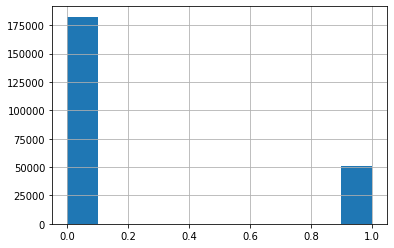

In [ ]:
y_train_init.hist()

In [ ]:
models_configurations_weighted = {
                                  "ExtraTreesClassifier": ExtraTreesClassifier(n_estimators=100, random_state=0, class_weight='balanced'),
                                  "LogisticRegression": LogisticRegression(random_state=0, class_weight='balanced'),
                                  "Decision Tree": DecisionTreeClassifier(max_depth=5, class_weight='balanced'),
                                  "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, class_weight='balanced'),
                                  "Neural Net": MLPClassifier(alpha=1, max_iter=1000),
                                  "Naive Bayes": GaussianNB(priors=[(y_train == 0).sum() / len(y_train), 1 - (y_train == 0).sum() / len(y_train)]),
                                  "QDA": QuadraticDiscriminantAnalysis(priors=[(y_train == 0).sum() / len(y_train), 1 - (y_train == 0).sum() / len(y_train)]),
                                  }

In [ ]:
X = RobustScaler().fit_transform(X_train_init)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_train_init, test_size=0.2, random_state=42, stratify=y_train_init,
)

metrics_clf = {'f1_score': f1_score, 
               'accuracy_score': accuracy_score, 
               'recall_score': recall_score, 
               'precision_score': precision_score}

res = {name: {} for name in models_configurations_weighted}


# iterate over classifiers
for name, clf in models_configurations_weighted.items():
    ts = time()
    print(f'{name} -> ', end='')
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_test)
    
    for metric_name, metric in metrics_clf.items():
        res[name][metric_name] = metric(y_test, y_val_pred)

    tn = time()
    print(colored('Done!', 'green', attrs=['bold']), end='\t')
    print(f'time: {tn - ts}')

ExtraTreesClassifier -> Done!	time: 48.4771945476532
LogisticRegression -> Done!	time: 1.132331132888794
Decision Tree -> Done!	time: 2.2063961029052734
Random Forest -> Done!	time: 0.8510403633117676
Neural Net -> Done!	time: 98.65947604179382
Naive Bayes -> Done!	time: 0.2414264678955078
QDA -> 

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done!	time: 1.1800739765167236


In [ ]:
from tabulate import tabulate
table = []
metrics_names = list(metrics_clf.keys())
for clf_name in res:
    table.append([colored(clf_name, 'blue'), *[colored(res[clf_name][m], 'grey') for m in metrics_names]])

headers = [colored('model', 'blue', attrs=['bold']), *[colored(m, 'grey', attrs=['bold']) for m in metrics_names]]
print(tabulate(table, headers=headers))

model                   f1_score    accuracy_score    recall_score    precision_score
--------------------  ----------  ----------------  --------------  -----------------
ExtraTreesClassifier  0.0398197           0.780747      0.0209445            0.403042
LogisticRegression    0.292479            0.673179      0.311203             0.27588
Decision Tree         0.391801            0.543737      0.67704              0.275664
Random Forest         0.374577            0.516116      0.667556             0.260325
Neural Net            0.00236546          0.782934      0.00118554           0.5
Naive Bayes           0.0167348           0.773198      0.00889152           0.141956
QDA                   0.380093            0.552315      0.632286             0.271716


In [ ]:
%%capture
!pip install imbalanced-learn

In [ ]:
models_configurations = {
                        #  "Nearest Neighbors": KNeighborsClassifier(3),
                         "ExtraTreesClassifier": ExtraTreesClassifier(n_estimators=100, random_state=0),
                         "LogisticRegression": LogisticRegression(random_state=0),
                         "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators=100, max_depth=7),
                         "Decision Tree": DecisionTreeClassifier(max_depth=5),
                         "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                         "Neural Net": MLPClassifier(alpha=1, max_iter=1000),
                         "AdaBoost": AdaBoostClassifier(),
                         "Naive Bayes": GaussianNB(),
                         "QDA": QuadraticDiscriminantAnalysis(),
                         }

In [ ]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)


metrics_clf = {'f1_score': f1_score, 
               'accuracy_score': accuracy_score, 
               'recall_score': recall_score, 
               'precision_score': precision_score}

res = {name: {} for name in models_configurations}


# iterate over classifiers
for name, clf in models_configurations.items():
    ts = time()
    print(f'{name} -> ', end='')
    clf.fit(X_train_sm, y_train_sm)
    y_val_pred = clf.predict(X_test)
    
    for metric_name, metric in metrics_clf.items():
        res[name][metric_name] = metric(y_test, y_val_pred)

    tn = time()
    print(colored('Done!', 'green', attrs=['bold']), end='\t')
    print(f'time: {tn - ts}')

ExtraTreesClassifier -> Done!	time: 107.83875703811646
LogisticRegression -> Done!	time: 1.8284273147583008
GradientBoostingClassifier -> Done!	time: 619.1750056743622
Decision Tree -> Done!	time: 4.654863357543945
Random Forest -> Done!	time: 1.5661859512329102
Neural Net -> Done!	time: 132.90084028244019
AdaBoost -> Done!	time: 57.11538290977478
Naive Bayes -> Done!	time: 0.4458653926849365
QDA -> 

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done!	time: 2.061772108078003


In [ ]:
from tabulate import tabulate
table = []
metrics_names = list(metrics_clf.keys())
for clf_name in res:
    table.append([colored(clf_name, 'blue'), *[colored(res[clf_name][m], 'grey') for m in metrics_names]])

headers = [colored('model', 'blue', attrs=['bold']), *[colored(m, 'grey', attrs=['bold']) for m in metrics_names]]
print(tabulate(table, headers=headers))

model                         f1_score    accuracy_score    recall_score    precision_score
--------------------------  ----------  ----------------  --------------  -----------------
ExtraTreesClassifier         0.152213           0.767086       0.0963248           0.362588
LogisticRegression           0.288083           0.677682       0.300435            0.276706
GradientBoostingClassifier   0.0969432          0.778259       0.0548311           0.417922
Decision Tree                0.377677           0.500204       0.698676            0.258782
Random Forest                0.344619           0.535481       0.562636            0.248375
Neural Net                   0.388875           0.575904       0.621616            0.282939
AdaBoost                     0.329714           0.663786       0.380952            0.290624
Naive Bayes                  0.357808           0.232292       0.98528             0.218596
QDA                          0.364672           0.368446       0.835013         

In [ ]:
models_configurations = {
                        #  "Nearest Neighbors": KNeighborsClassifier(3),
                         "ExtraTreesClassifier": ExtraTreesClassifier(n_estimators=100, random_state=0),
                         "LogisticRegression": LogisticRegression(random_state=0),
                         "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators=100, max_depth=7),
                         "Decision Tree": DecisionTreeClassifier(max_depth=5),
                         "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                         "Neural Net": MLPClassifier(alpha=1, max_iter=1000),
                         "AdaBoost": AdaBoostClassifier(),
                         "Naive Bayes": GaussianNB(),
                         "QDA": QuadraticDiscriminantAnalysis(),
                         }

In [ ]:
from imblearn.over_sampling import RandomOverSampler


oversample = RandomOverSampler(sampling_strategy='minority')
X_train_o, y_train_o = oversample.fit_resample(X_train, y_train)


metrics_clf = {'f1_score': f1_score, 
               'accuracy_score': accuracy_score, 
               'recall_score': recall_score, 
               'precision_score': precision_score}

res = {name: {} for name in models_configurations}


# iterate over classifiers
for name, clf in models_configurations.items():
    ts = time()
    print(f'{name} -> ', end='')
    clf.fit(X_train_o, y_train_o)
    y_val_pred = clf.predict(X_test)
    
    for metric_name, metric in metrics_clf.items():
        res[name][metric_name] = metric(y_test, y_val_pred)

    tn = time()
    print(colored('Done!', 'green', attrs=['bold']), end='\t')
    print(f'time: {tn - ts}')

ExtraTreesClassifier -> Done!	time: 111.42731165885925
LogisticRegression -> Done!	time: 1.961428165435791
GradientBoostingClassifier -> Done!	time: 472.7315640449524
Decision Tree -> Done!	time: 3.7151331901550293
Random Forest -> Done!	time: 1.3694820404052734
Neural Net -> Done!	time: 114.89477777481079
AdaBoost -> Done!	time: 44.67167806625366
Naive Bayes -> Done!	time: 0.49166369438171387
QDA -> 

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done!	time: 2.1034047603607178


In [ ]:
from tabulate import tabulate
table = []
metrics_names = list(metrics_clf.keys())
for clf_name in res:
    table.append([colored(clf_name, 'blue'), *[colored(res[clf_name][m], 'grey') for m in metrics_names]])

headers = [colored('model', 'blue', attrs=['bold']), *[colored(m, 'grey', attrs=['bold']) for m in metrics_names]]
print(tabulate(table, headers=headers))

model                         f1_score    accuracy_score    recall_score    precision_score
--------------------------  ----------  ----------------  --------------  -----------------
ExtraTreesClassifier         0.0375755          0.78139        0.0196601           0.423404
LogisticRegression           0.292804           0.671206       0.313574            0.274615
GradientBoostingClassifier   0.409901           0.618601       0.610255            0.308588
Decision Tree                0.389237           0.55461        0.653823            0.277101
Random Forest                0.375628           0.536317       0.642561            0.265383
Neural Net                   0.394998           0.534173       0.700553            0.275037
AdaBoost                     0.397434           0.589093       0.624284            0.291507
Naive Bayes                  0.0344108          0.761704       0.0195614           0.142857
QDA                          0.384521           0.463833       0.771587         

In [ ]:
models_configurations = {
                        #  "Nearest Neighbors": KNeighborsClassifier(3),
                         "ExtraTreesClassifier": ExtraTreesClassifier(n_estimators=100, random_state=0),
                         "LogisticRegression": LogisticRegression(random_state=0),
                         "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators=100, max_depth=7),
                         "Decision Tree": DecisionTreeClassifier(max_depth=5),
                         "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                         "Neural Net": MLPClassifier(alpha=1, max_iter=1000),
                         "AdaBoost": AdaBoostClassifier(),
                         "Naive Bayes": GaussianNB(),
                         "QDA": QuadraticDiscriminantAnalysis(),
                         }

In [ ]:
from imblearn.over_sampling import ADASYN

oversample = ADASYN()
X_train_o, y_train_o = oversample.fit_resample(X_train, y_train)


metrics_clf = {'f1_score': f1_score, 
               'accuracy_score': accuracy_score, 
               'recall_score': recall_score, 
               'precision_score': precision_score}

res = {name: {} for name in models_configurations}


# iterate over classifiers
for name, clf in models_configurations.items():
    ts = time()
    print(f'{name} -> ', end='')
    clf.fit(X_train_o, y_train_o)
    y_val_pred = clf.predict(X_test)
    
    for metric_name, metric in metrics_clf.items():
        res[name][metric_name] = metric(y_test, y_val_pred)

    tn = time()
    print(colored('Done!', 'green', attrs=['bold']), end='\t')
    print(f'time: {tn - ts}')

ExtraTreesClassifier -> Done!	time: 85.21103096008301
LogisticRegression -> Done!	time: 3.4064321517944336
GradientBoostingClassifier -> Done!	time: 539.8652124404907
Decision Tree -> Done!	time: 4.076112270355225
Random Forest -> Done!	time: 1.4349210262298584
Neural Net -> Done!	time: 115.52731776237488
AdaBoost -> Done!	time: 51.449212074279785
Naive Bayes -> Done!	time: 0.4643893241882324
QDA -> 

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done!	time: 1.8639373779296875


In [ ]:
from tabulate import tabulate
table = []
metrics_names = list(metrics_clf.keys())
for clf_name in res:
    table.append([colored(clf_name, 'blue'), *[colored(res[clf_name][m], 'grey') for m in metrics_names]])

headers = [colored('model', 'blue', attrs=['bold']), *[colored(m, 'grey', attrs=['bold']) for m in metrics_names]]
print(tabulate(table, headers=headers))

model                         f1_score    accuracy_score    recall_score    precision_score
--------------------------  ----------  ----------------  --------------  -----------------
ExtraTreesClassifier          0.145469          0.768459       0.0907923           0.365698
LogisticRegression            0.269928          0.697926       0.257261            0.283908
GradientBoostingClassifier    0.082692          0.780189       0.0456432           0.439163
Decision Tree                 0.288602          0.670991       0.307449            0.271933
Random Forest                 0.349411          0.601102       0.49348             0.270453
Neural Net                    0.38811           0.562094       0.639795            0.278538
AdaBoost                      0.323462          0.666381       0.367418            0.288899
Naive Bayes                   0.357809          0.235144       0.981624            0.218778
QDA                           0.363609          0.364264       0.836692         